In [5]:
import pandas as pd
from sklearn.metrics import *
from tqdm import tqdm
from utils import HeteroDataProcessor,HeteroDataProcessorFilterNodeonTest
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn

import torch_geometric.transforms as T
from torch_geometric.datasets import DBLP
from torch_geometric.nn import HANConv, Linear


In [6]:

# Usage
file_path_replies = r"/home/azureuser/rumour-detection-pheme/replies_charlie_hebdo.pkl"
file_path_posts = r"/home/azureuser/rumour-detection-pheme/posts_charlie_hebdo.pkl"

time_cut =30

processor = HeteroDataProcessorFilterNodeonTest(file_path_replies, file_path_posts, time_cut)
data = processor.process()


/home/azureuser/rumour-detection-pheme/utils.py:485: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_val_reply_features[['reply_followers','time_diff']] = scaler_replies.transform(test_val_reply_features[['reply_followers','time_diff']])


In [3]:
data

HeteroData(
  id={
    x=[1429, 106],
    y=[1429],
    train_mask=[1429],
    val_mask=[1429],
    test_mask=[1429],
  },
  reply_user_id={ x=[13314, 104] },
  (id, retweet, reply_user_id)={ edge_index=[2, 13314] },
  (reply_user_id, rev_retweet, id)={ edge_index=[2, 13314] }
)

In [7]:
class HAN(nn.Module):
    def __init__(self, dim_in, dim_out, dim_h=64, heads=4):
        super().__init__()
        self.han = HANConv(dim_in, dim_h, heads=heads,dropout=0.2, metadata=data.metadata())
        self.han2 = HANConv(dim_h, dim_h, heads=heads, dropout=0.2, metadata=data.metadata())
        self.linear = nn.Linear(dim_h, dim_out)

    def forward(self, x_dict, edge_index_dict):
        out = self.han(x_dict, edge_index_dict)
        out = self.han2(out, edge_index_dict)
        out = self.linear(out['id'])
        return out
    
@torch.no_grad()
def test(mask):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)
    acc = (pred[mask] == data['id'].y[mask]).sum() / mask.sum()
    return float(acc)

In [6]:
model = HAN(dim_in=-1, dim_out=2)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data, model = data.to(device), model.to(device)

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['id'].train_mask
    loss = F.cross_entropy(out[mask], data['id'].y[mask])
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        train_acc = test(data['id'].train_mask)
        val_acc = test(data['id'].val_mask)
        print(f'Epoch: {epoch:>3} | Train Loss: {loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%')

test_acc = test(data['id'].test_mask)
print(f'Test accuracy: {test_acc*100:.2f}%')

Epoch:   0 | Train Loss: 0.9565 | Train Acc: 63.53% | Val Acc: 7.14%
Epoch:  20 | Train Loss: 0.5085 | Train Acc: 77.66% | Val Acc: 0.00%
Epoch:  40 | Train Loss: 0.4159 | Train Acc: 79.66% | Val Acc: 7.14%
Epoch:  60 | Train Loss: 0.3546 | Train Acc: 83.51% | Val Acc: 35.71%
Epoch:  80 | Train Loss: 0.3204 | Train Acc: 85.22% | Val Acc: 50.00%
Epoch: 100 | Train Loss: 0.2866 | Train Acc: 87.22% | Val Acc: 50.00%
Epoch: 120 | Train Loss: 0.2658 | Train Acc: 88.01% | Val Acc: 71.43%
Epoch: 140 | Train Loss: 0.2347 | Train Acc: 89.36% | Val Acc: 78.57%
Epoch: 160 | Train Loss: 0.2087 | Train Acc: 90.58% | Val Acc: 78.57%
Epoch: 180 | Train Loss: 0.1635 | Train Acc: 91.86% | Val Acc: 78.57%
Test accuracy: 92.86%


In [7]:
test_mask = data['id'].test_mask | data['id'].val_mask
pred =model(data.x_dict, data.edge_index_dict).argmax(dim=-1)
true_labels = data['id'].y[test_mask]
pred_labels = pred[test_mask]
precision_score(true_labels, pred_labels, average='macro')

0.8615384615384616

In [8]:
recall_score(true_labels, pred_labels, average='macro')

0.8615384615384616

In [8]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
#mlflow.set_experiment("spyder-experiment")
import mlflow.pytorch
mlflow.set_experiment("HAN 2024-10-03 2 layers Filter Node Test 12min-3days")

<Experiment: artifact_location='/home/azureuser/rumour-detection-pheme/mlruns/36', creation_time=1728004017687, experiment_id='36', last_update_time=1728004017687, lifecycle_stage='active', name='HAN 2024-10-03 2 layers Filter Node Test 12min-3days', tags={}>

In [9]:
#
file_path_replies = r"/home/azureuser/rumour-detection-pheme/replies_charlie_hebdo.pkl"
file_path_posts = r"/home/azureuser/rumour-detection-pheme/posts_charlie_hebdo.pkl"

for time_cut in range(4272,24*3*60,10):
    print(time_cut)
    processor = HeteroDataProcessorFilterNodeonTest(file_path_replies, file_path_posts, time_cut)
    data = processor.process()

    model = HAN(dim_in=-1, dim_out=2)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data, model = data.to(device), model.to(device)
   
    with mlflow.start_run():

        for epoch in range(200):
            model.train()
            optimizer.zero_grad()
            out = model(data.x_dict, data.edge_index_dict)
            mask = data['id'].train_mask
            loss = F.cross_entropy(out[mask], data['id'].y[mask])
            loss.backward()
            optimizer.step()

        if epoch % 20 == 0:
            train_acc = test(data['id'].train_mask)
            val_acc = test(data['id'].val_mask)
            print(f'Epoch: {epoch:>3} | Train Loss: {loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%')

        test_acc = test(data['id'].test_mask)
        train_acc = test(data['id'].train_mask)
        val_acc = test(data['id'].val_mask)
        print(f'Test accuracy: {test_acc*100:.2f}%')



        test_mask = data['id'].test_mask | data['id'].val_mask
        pred =model(data.x_dict, data.edge_index_dict).argmax(dim=-1)
        true_labels = data['id'].y[test_mask]
        pred_labels = pred[test_mask]
        test_precision =precision_score(true_labels, pred_labels, average='macro')
        test_recall=recall_score(true_labels, pred_labels, average='macro')
        print(f'Test Recall: {test_recall*100:.2f}%')
        print(f'Test Precision: {test_precision*100:.2f}%')

        mlflow.log_metric("train_loss", loss.item(), step=epoch)
        mlflow.log_metric("train_acc", train_acc, step=epoch)
        mlflow.log_metric("val_acc", val_acc, step=epoch)
        mlflow.log_metric("test_acc", test_acc)
        mlflow.log_metric("test_precision",  test_precision)
        mlflow.log_metric("test_recall",  test_recall)

            
        mlflow.log_param("learning_rate", 0.001)
        mlflow.log_param("epochs", 200)
        mlflow.log_metric("time_cut", time_cut)



        
            
        mlflow.pytorch.log_model(model, f"HAN_model_{time_cut}")


4272


/home/azureuser/rumour-detection-pheme/utils.py:485: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_val_reply_features[['reply_followers','time_diff']] = scaler_replies.transform(test_val_reply_features[['reply_followers','time_diff']])


Test accuracy: 87.67%
Test Recall: 76.95%
Test Precision: 76.95%


2024/10/05 14:54:58 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4282


/home/azureuser/rumour-detection-pheme/utils.py:485: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_val_reply_features[['reply_followers','time_diff']] = scaler_replies.transform(test_val_reply_features[['reply_followers','time_diff']])


Test accuracy: 86.33%
Test Recall: 80.63%
Test Precision: 78.46%


2024/10/05 14:56:47 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4292


/home/azureuser/rumour-detection-pheme/utils.py:485: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_val_reply_features[['reply_followers','time_diff']] = scaler_replies.transform(test_val_reply_features[['reply_followers','time_diff']])


Test accuracy: 90.33%
Test Recall: 78.02%
Test Precision: 79.65%


2024/10/05 14:58:30 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4302


/home/azureuser/rumour-detection-pheme/utils.py:485: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_val_reply_features[['reply_followers','time_diff']] = scaler_replies.transform(test_val_reply_features[['reply_followers','time_diff']])


Test accuracy: 89.33%
Test Recall: 77.38%
Test Precision: 77.98%


2024/10/05 15:00:17 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4312


/home/azureuser/rumour-detection-pheme/utils.py:485: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_val_reply_features[['reply_followers','time_diff']] = scaler_replies.transform(test_val_reply_features[['reply_followers','time_diff']])


Test accuracy: 87.67%
Test Recall: 75.72%
Test Precision: 76.00%


2024/10/05 15:02:03 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [3]:
24*3*60

4320

In [10]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
# Get the experiment ID or name
experiment_name = "HAN 2024-10-03 2 layers Filter Node Test 12min-3days"  # Replace with your experiment name
experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment is not None:
    experiment_id = experiment.experiment_id

    # Retrieve all runs in the experiment as a DataFrame
    df = mlflow.search_runs(experiment_ids=[experiment_id])
    
    # Show the DataFrame
    #print(df)
else:
    print(f"Experiment '{experiment_name}' not found.")


In [2]:
df['metrics.time_cut'].max()

4262.0

In [11]:

today = pd.Timestamp.now(tz='UTC').normalize()

# Filter DataFrame for dates lower than today
df = df[(df['start_time'] < today)|((df['start_time'] > today) & (df['metrics.time_cut']>1852))]

In [3]:
df = df[['run_id','metrics.time_cut', 'metrics.train_loss',
       'metrics.train_acc', 'metrics.test_acc', 'metrics.test_precision',
       'metrics.test_recall', 'metrics.val_acc']]

In [4]:
df.to_csv("HAN_2024_09_28_2_layers_Filter_Node_17min_3days")

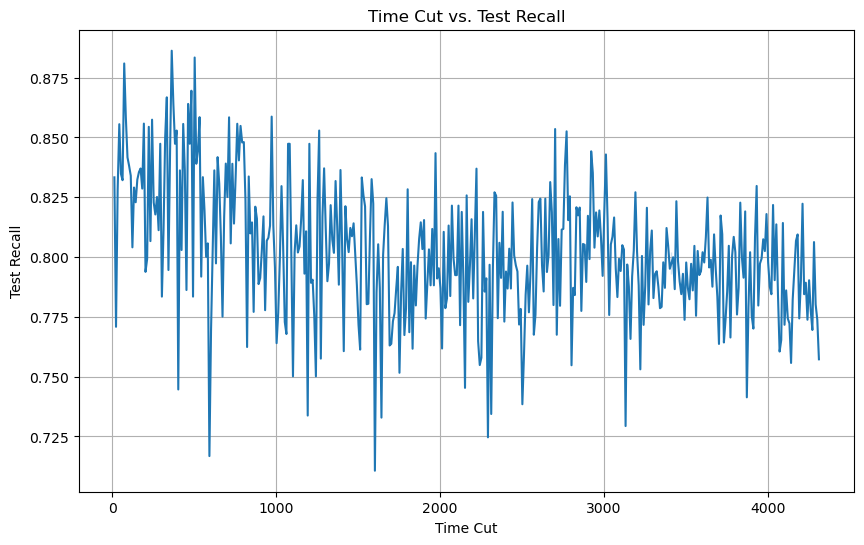

In [12]:
    # Ensure the metrics are numeric
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df['metrics.time_cut'] = pd.to_numeric(df['metrics.time_cut'], errors='coerce')
df['metrics.test_recall'] = pd.to_numeric(df['metrics.test_recall'], errors='coerce')
    
# Plotting time_cut vs. test_accuracy
plt.figure(figsize=(10, 6))
sns.lineplot(x='metrics.time_cut', y='metrics.test_recall', data=df)
plt.title('Time Cut vs. Test Recall')
plt.xlabel('Time Cut')
plt.ylabel('Test Recall')
plt.grid(True)
plt.show()

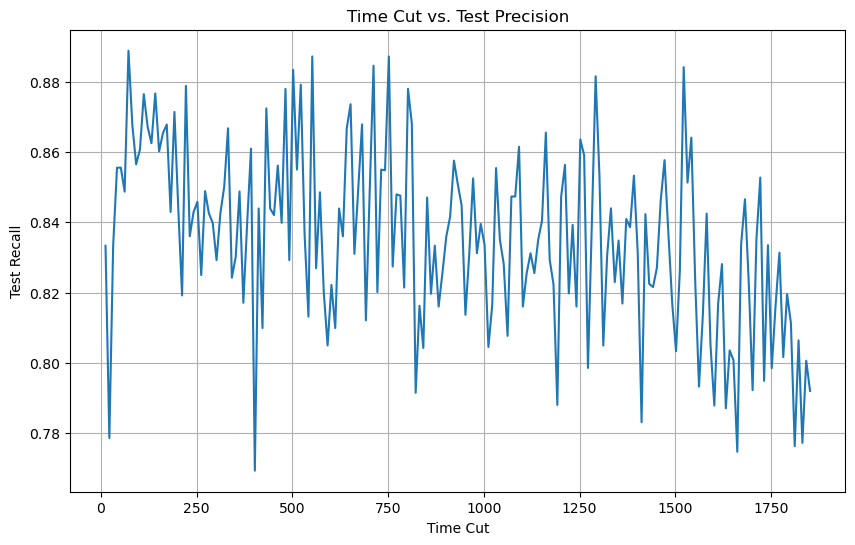

In [20]:
    # Ensure the metrics are numeric
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df['metrics.time_cut'] = pd.to_numeric(df['metrics.time_cut'], errors='coerce')
df['metrics.test_precision'] = pd.to_numeric(df['metrics.test_precision'], errors='coerce')
    
# Plotting time_cut vs. test_accuracy
plt.figure(figsize=(10, 6))
sns.lineplot(x='metrics.time_cut', y='metrics.test_precision', data=df)
plt.title('Time Cut vs. Test Precision')
plt.xlabel('Time Cut')
plt.ylabel('Test Recall')
plt.grid(True)
plt.show()